In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../tools/sampling_utils')

from easydict import EasyDict as edict
import torch
import numpy as np
from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)
from collections import defaultdict
from functools import partial
import time
from matplotlib import pyplot as plt


In [3]:
from ebm_sampling import mala_dynamics
from sir_ais_sampling import sir_independent_dynamics
from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from distributions import (Target, 
                           Banana,
                           Funnel,
                           IndependentNormal,
                           init_independent_normal,
                           init_independent_normal_scale)
from metrics import Evolution

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def autocovariance(X, tau=0):
    #dT, dX = np.shape(X)
    dT = X.shape[0]
    s = 0.
    dN = 1
    if tau > 0:
        x1 = X[:-tau, ...]
    else:
        x1 = X
    x2 = X[tau:, ...]
    s = np.sum(x1 * x2, axis=0) / dN

    return s / (dT - tau)


def acl_spectrum(X, scale=1):
    n = 150 #X.shape[0]
    scale = np.sqrt(autocovariance(X, tau=0))
    return np.stack([autocovariance(X / (scale[None, ...] + 1e-7), tau=t) for t in range(n - 1)], axis=0)


def ESS(A):
    A = A * (A > 0.05)
    ess = 1. / (1. + 2 * np.sum(A[1:, ...], axis=0))
    return ess

In [7]:
# banana

args = edict()
args.loc_proposal = 0
args.scale_proposal = 1
args.dim = 32
args.batch_size = 200
args.device = device


In [8]:
# equal number of steps (1000)

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 3000
method_args.N = 20
methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 3000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['mala'] = partial(mala_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 3000
method_args.mala_steps = 1
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 20
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala'] = partial(ex2_mcmc_mala, **method_args)

dim = args.dim
samples = []

target = Banana(args)
# target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

for method_name, call in methods_calls.items():

    start = proposal.sample([args.batch_size])

    s = time.time()
    # hardcode
    if method_name == 'isir':
        out = call(start, target, proposal)
    else:
        out = call(start, target.log_prob, proposal)
    e = time.time()
    elapsed = (e - s) #/ 60
    if isinstance(out, tuple):
        sample = out[0]
    else:
        sample = out
    
    trunc_chain_len = int(0.9 * len(sample))

    ess_arr = []
    sample = torch.stack(sample, 0).detach().cpu().numpy()
    trunc_sample = sample[-trunc_chain_len:]
    batch_size = sample.shape[1]
    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]))).mean()
    print(f'Method: {method_name}, ESS: {ess:.4f}, sampling time: {elapsed:.2f}')

    samples.append(trunc_sample)



Method: isir, ESS: 0.0068, sampling time: 14.80
Method: mala, ESS: 0.0045, sampling time: 19.14
Method: ex2_mcmc_mala, ESS: 0.0046, sampling time: 41.76


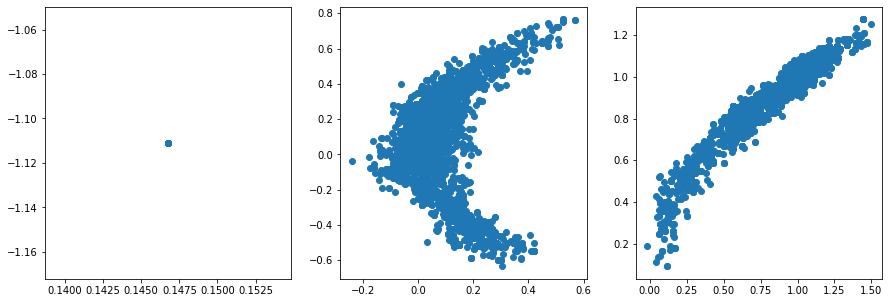

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

batch_idx = np.random.randint(0, args.batch_size)

for sample, ax in zip(samples, axs.flatten()):
    ax.scatter(sample[:,batch_idx, 0], sample[:,batch_idx, 1])
plt.show()

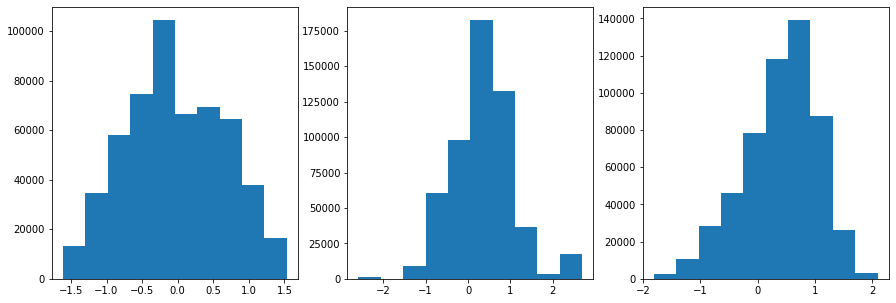

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for sample, ax in zip(samples, axs.flatten()):
    ax.hist(sample[:,:, 1].flatten())
plt.show()

In [11]:
# funnel

args.dim = 16

In [12]:
# equal number of steps (1000)

methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = 3000
method_args.N = 20
methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 3000
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['mala'] = partial(mala_dynamics, **method_args)

method_args = edict()
method_args.n_steps = 3000
method_args.mala_steps = 1
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 20
method_args.corr_coef = 0.95
method_args.bernoulli_prob_corr = 0.1
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala'] = partial(ex2_mcmc_mala, **method_args)

dim = args.dim
samples = []

target = Funnel(args)
# target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob
proposal = init_independent_normal(args.scale_proposal, dim, device, args.loc_proposal)

for method_name, call in methods_calls.items():

    start = proposal.sample([args.batch_size])

    s = time.time()
    # hardcode
    if method_name == 'isir':
        out = call(start, target, proposal)
    else:
        out = call(start, target.log_prob, proposal)
    e = time.time()
    elapsed = (e - s) #/ 60
    if isinstance(out, tuple):
        sample = out[0]
    else:
        sample = out
    
    trunc_chain_len = int(0.9 * len(sample))

    ess_arr = []
    sample = torch.stack(sample, 0).detach().cpu().numpy()
    trunc_sample = sample[-trunc_chain_len:]
    batch_size = sample.shape[1]
    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]))).mean()
    print(f'Method: {method_name}, ESS: {ess:.4f}, sampling time: {elapsed:.2f}')

    samples.append(trunc_sample)



Method: isir, ESS: 0.0073, sampling time: 14.44
Method: mala, ESS: 0.0046, sampling time: 12.03
Method: ex2_mcmc_mala, ESS: 0.0046, sampling time: 31.27


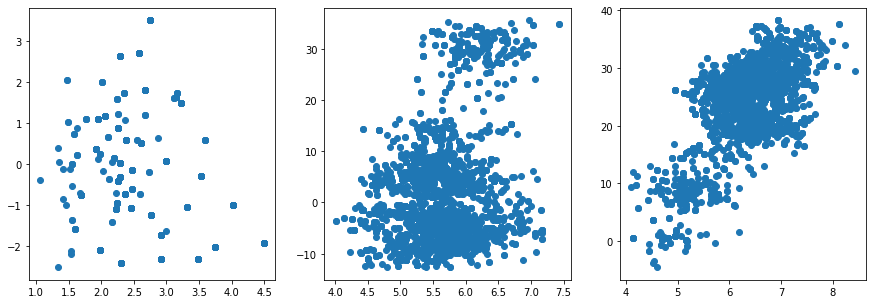

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

batch_idx = np.random.randint(0, args.batch_size)

for sample, ax in zip(samples, axs.flatten()):
    ax.scatter(sample[:,batch_idx, 0], sample[:,batch_idx, 1])
plt.show()

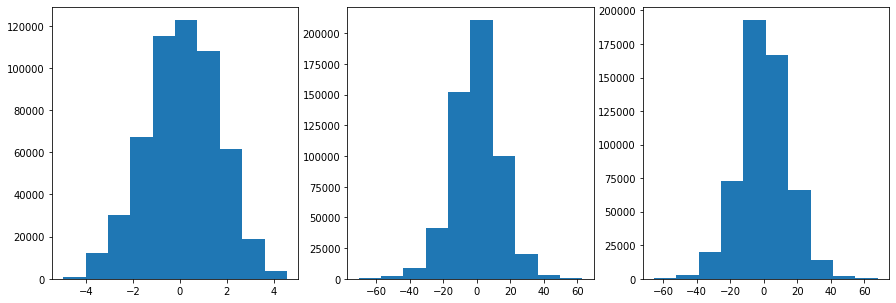

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for sample, ax in zip(samples, axs.flatten()):
    ax.hist(sample[:,:, 1].flatten())
plt.show()